In [25]:
!pip install -q mmh3==3.0.0
!pip freeze | grep mmh3

mmh3==3.0.0


## part 1 code copied over for reference

In [1]:
import functools
import mmh3
import numpy as np
import string
from dataclasses import dataclass
from typing import Set

ServerId = str

SEED = 0


def hash_mmh3(key: str, seed: int = SEED) -> int:
    return mmh3.hash(key, seed=seed)


def random_str() -> str:
    return "".join(np.random.choice(
        # select from lowercase letters
        list(string.ascii_lowercase),
        # generate a string that's between 6 to 20
        # characters long
        size=np.random.randint(6, 20),
        replace=True,
    ))


@dataclass(frozen=True)
class Server:
    server_id: ServerId
    seed: int = SEED
        
    @property
    @functools.lru_cache()
    def hash_value(self) -> int:
        return hash_mmh3(key=self.server_id, seed=self.seed)
        
    def __lt__(self, other: "Server") -> bool:
        return self.hash_value < other.hash_value

    
class ConsistentHashing:
    def __init__(self, server_ids: Set[str], seed: int = SEED):
        assert len(server_ids) > 0
        self._seed = seed
        self._server_ids = server_ids
        self._server_allocations = None
        self._allocate_servers()
        
    def key_lookup(self, key: str) -> ServerId:
        """
        Allocate `key` to a server.
        """
        key_hash = hash_mmh3(key=key, seed=self._seed)
        # compute the distance between the hash value of
        # the input key and each server's hash
        distances = (
            (key_hash - server_obj.hash_value, server_id)
            for server_id, server_obj
            in self._server_allocations.items()
        )
        # find the server with the smallest positive distance
        # assign None if no such server exists
        # which means that the server with the largest hash is
        # responsible for this key
        closest = min((
            (dist, server_id)
            for dist, server_id in distances
            if dist >= 0
        ), default=None)
        return (
            # get the ID of the server with the largest hash value
            max(self._server_allocations.values()).server_id
            if closest is None
            else closest[1]
        )
        
    def add_server(self, server_id: ServerId) -> None:
        if server_id in self._server_allocations:
            raise ValueError(
                f"server_id={server_id} already exist."
            )
        self._server_ids.add(server_id)
        self._add_server(server_id=server_id)
    
    def remove_server(self, server_id: ServerId) -> None:
        if server_id not in self._server_allocations:
            raise ValueError(
                f"server_id={server_id} does not exist"
            )
        if len(self._server_allocations) == 1:
            raise ValueError(
                "only one server left- cannot delete"
            )
        self._server_ids.remove(server_id)
        self._remove_server(server_id=server_id)
        
    def _allocate_servers(self):
        """
        Map servers to the ring given the
        current set of server IDs.
        """
        self._server_allocations = {
            server_id: Server(
                server_id=server_id,
                seed=self._seed,
            )
            for server_id in self._server_ids
        }
        
    def _add_server(self, server_id: ServerId) -> None:
        self._server_allocations[server_id] = Server(
            server_id=server_id,
            seed=self._seed,
        )
        
    def _remove_server(self, server_id: ServerId) -> None:
        del self._server_allocations[server_id]

## part 2 code starts here

### 1. Is consistent hashing optimal?

In [2]:
import pandas as pd
from typing import List, Optional, Sequence, Type


def consistent_hashing_same_allocations(
    n: int,
    urls: List[str],
    ch_cls: ConsistentHashing,
) -> float:
    ch = ch_cls(server_ids={
        random_str() for _ in range(n)
    })
    allocs = {
        url: ch.key_lookup(key=url)
        for url in urls
    }
    ch.add_server(server_id=random_str())
    return sum(
        allocs[url] == ch.key_lookup(key=url)
        for url in urls
    ) / len(urls)


def run_exp(
    ns: Sequence[int],
    experiment_cnt: int,
    ch_cls: Type[ConsistentHashing],
) -> pd.DataFrame:
    return pd.DataFrame(
        dict(
            n=n,
            idx_experiment=idx_experiment,
            same_alloc=consistent_hashing_same_allocations(
                n=n,
                urls=urls,
                ch_cls=ch_cls,
            ),
        )
        for n in ns
        for idx_experiment in range(experiment_cnt)
    )

In [3]:
%%time
url_cnt = 10_000
urls = [random_str() for _ in range(url_cnt)]
ns = (1, 2, 5, 10, 20, 50, 100)
experiment_cnt = 100

df_experiment_same_alloc = run_exp(
    ns=ns,
    experiment_cnt=experiment_cnt,
    ch_cls=ConsistentHashing,
)

CPU times: user 2min 41s, sys: 319 ms, total: 2min 42s
Wall time: 2min 42s


In [4]:
def ideal(n): return n / (n + 1)

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df_ideal = pd.DataFrame([
    dict(
        n=n,
        idx_experiment=0,
        same_alloc=ideal(n),
    )
    for n in ns
]),

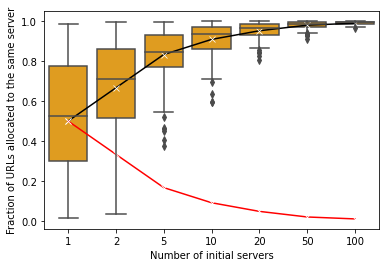

In [7]:
sns.lineplot(x=list(map(str, ns)), y=list(map(ideal, ns)), marker='x', color='black')
sns.lineplot(x=list(map(str, ns)), y=list(map(lambda n: 1 / (n + 1), ns)), marker='x', color='red')

sns.boxplot(
    x='n',
    y='same_alloc',
    data=df_experiment_same_alloc,
    color='orange'
)
plt.xlabel('Number of initial servers')
_ = plt.ylabel('Fraction of URLs allocated to the same server')
# plt.legend()

#### Tokens

In [8]:
class ConsistentHashingWithTokensNaive:
    def __init__(
        self,
        server_ids: Set[ServerId],
        k: int,
        seed: int = SEED,
    ):
        server_ids_virtual = {
            f"{server_id}-{idx}"
            for server_id in server_ids
            for idx in range(k)
        }
        self.k = k
        self.ch = ConsistentHashing(
            server_ids=server_ids_virtual,
            seed=seed,
        )
        
    def key_lookup(self, key: str) -> ServerId:
        server_id_virtual = self.ch.key_lookup(key=key)
        return "-".join(server_id_virtual.split("-")[:-1])
    
    def add_server(self, server_id: ServerId) -> None:
        for idx in range(self.k):
            self.ch.add_server(server_id=f"{server_id}-{idx}")
    
    def remove_server(self, server_id: ServerId) -> None:
        for idx in range(self.k):
            self.ch.remove_server(server_id=f"{server_id}-{idx}")

In [9]:
ch = ConsistentHashingWithTokensNaive(
    server_ids={"a", "b", "c"},
    k=1_000,
)

first = ch.key_lookup('z')
ch.add_server('d')
second = ch.key_lookup('z')
[first, second]

['a', 'a']

CPU times: user 2min 24s, sys: 496 ms, total: 2min 24s
Wall time: 2min 25s


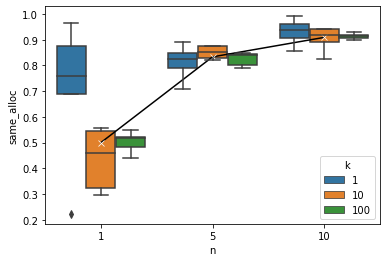

In [10]:
%%time
df = pd.concat([
    run_exp(
        ns=(1, 5, 10),
        experiment_cnt=5,
        ch_cls=functools.partial(
            ConsistentHashingWithTokensNaive,
            k=k,
        ),
    ).assign(k=k)
    for k in (1, 10, 100)
])

sns.lineplot(x=list(map(str, (1, 5, 10))), y=list(map(ideal, (1, 5, 10))), marker='x', color='black')
_ = sns.boxplot(
    x='n',
    y='same_alloc',
    data=df,
    hue='k',
)

#### slices

In [11]:
from collections import defaultdict


def compute_slices(
    n: int,
    k: int,
    seed: Optional[int] = None,
) -> List[float]:
    np.random.seed(seed)
    tokens = np.random.rand(n * k)
    servers = np.random.choice(range(n), n * k)
    idxs = np.argsort(tokens)
    fractions = defaultdict(int)
    for idx_prev, idx in zip(idxs, idxs[1:]):
        server_prev = servers[idx_prev]
        diff = tokens[idx] - tokens[idx_prev]
        fractions[server_prev] += diff
        
    last = 1 - tokens[idxs[-1]]
    last += tokens[idxs[0]]
    fractions[servers[-1]] += last
    assert sum(fractions.values()) == 1
    return fractions

df_slices = pd.DataFrame(
    dict(
        k=k,
        exp_idx=exp_idx,
        server1=compute_slices(n=5, k=k, seed=exp_idx)[0],
    )
    for k in (1, 5, 10, 100, 1000, 10_000)
    for exp_idx in range(100)
).fillna(0)

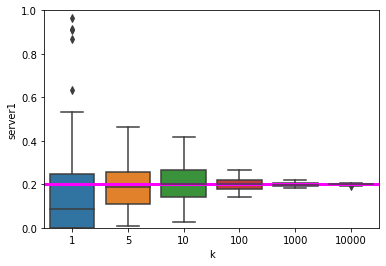

In [12]:
sns.boxplot(
    x='k',
    y='server1',
    data=df_slices,
    # hue='k',
)
plt.axhline(y=0.2, color='magenta', linestyle='-', linewidth=3)
_ = plt.ylim([0, 1])

### 2. Allocation by capacity

In [13]:
@dataclass(frozen=True)
class ServerToken:
    server_id: ServerId
    token_idx: int
    _seed: int = SEED
        
    @property
    @functools.lru_cache()
    def key(self) -> str:
        return f"{self.server_id}-{self.token_idx}"
        
    @property
    @functools.lru_cache()
    def hash_value(self) -> int:
        return hash_mmh3(key=self.key, seed=self._seed)
        
    def __lt__(self, other: "ServerToken") -> bool:
        return self.hash_value < other.hash_value

In [14]:
from typing import Dict

class ConsistentHashingWithTokens:
    def __init__(
        self,
        server_tokens: Dict[ServerId, int],
        seed: int = SEED,
    ):
        pass

In [15]:
from typing import Iterable, Tuple


class ConsistentHashingWithTokens:
    def __init__(
        self,
        server_tokens: Dict[ServerId, int],
        seed: int = SEED,
    ):
        assert all(tokens >= 1 for tokens in server_tokens.values())
        self._seed = seed
        self._server_tokens = server_tokens
        self._allocate_servers()
        
    def key_lookup(self, key: str) -> ServerToken:
        key_hash = ServerToken(
            server_id=key,
            token_idx=0,  # dummy value
            _seed=self._seed,
        ).hash_value
        distances = (
            (
                key_hash - server_token_obj.hash_value,
                server_id,
            )
            for (server_id, _), server_token_obj
            in self._server_allocations.items()
        )
        return self._find_closest(distances=distances)
    
    def _find_closest(
        self,
        distances: Iterable[Tuple[int, ServerId]],
    ) -> ServerId:
        # find the server with the smallest positive distance
        # assign None if no such server exists
        # which means that the server with the largest hash is
        # responsible for this key
        closest = min((
            (dist, server_id)
            for dist, server_id in distances
            if dist >= 0
        ), default=None)
        return (
            # get the ID of the server with the largest hash value
            max(self._server_allocations.values()).server_id
            if closest is None
            else closest[1]
        )
        
    def _allocate_servers(self):
        self._server_allocations = {
            (server_id, token_idx): ServerToken(
                server_id=server_id,
                token_idx=token_idx,
                _seed=self._seed,
            )
            for server_id, token_count in self._server_tokens.items()
            for token_idx in range(token_count)
        }

In [16]:
def experiment_capacity(a_tokens: int) -> float:
    assert a_tokens >= 2 and a_tokens % 2 == 0
    a = random_str()
    b = random_str()
    ch = ConsistentHashingWithTokens(
        server_tokens={a: a_tokens, b: a_tokens // 2},
    )
    return sum(
        ch.key_lookup(key=url) == a
        for url in urls
    ) / len(urls)

CPU times: user 1min 13s, sys: 335 ms, total: 1min 14s
Wall time: 1min 14s


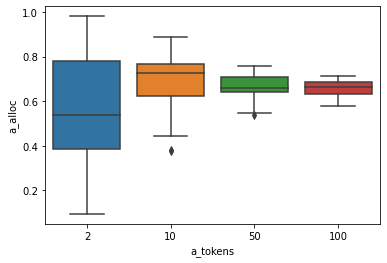

In [17]:
%%time
df_experiment_capacity = pd.DataFrame(
    dict(
        a_tokens=a_tokens,
        experiment_idx=experiment_idx,
        a_alloc=experiment_capacity(a_tokens=a_tokens),
    )
    for a_tokens in (2, 10, 50, 100)
    for experiment_idx in range(30)
) 

_ = sns.boxplot(
    x='a_tokens',
    y='a_alloc',
    data=df_experiment_capacity,
)

In [18]:
def alloc(
    ch: ConsistentHashingWithTokens,
) -> pd.Series:
    return pd.Series(
        ch.key_lookup(url)
        for url in urls
    ).value_counts(normalize=True)

In [19]:
%%time
ch = ConsistentHashingWithTokens({'a': 100, 'b': 400, 'c': 500})
alloc(ch=ch)

CPU times: user 13.1 s, sys: 202 ms, total: 13.3 s
Wall time: 13 s


c    0.5202
b    0.3832
a    0.0966
dtype: float64

In [20]:
class ConsistentHashingWithTokens:
    def __init__(
        self,
        server_tokens: Dict[ServerId, int],
        seed: int = SEED,
    ):
        assert all(tokens >= 1 for tokens in server_tokens.values())
        self._seed = seed
        self._server_tokens = server_tokens
        self._update_token_hashes()
        
    def _update_token_hashes(self):
        self._server_allocations = {
            (server_id, token_idx): ServerToken(server_id=server_id, token_idx=token_idx, _seed=self._seed)
            for server_id, token_count in self._server_tokens.items()
            for token_idx in range(token_count)
        }
        
    @classmethod
    def equal_tokens(
        cls,
        servers: Set[ServerId],
        tokens: int = 1,
        seed: int = SEED,
    ) -> "ConsistentHashingWithTokens":
        return cls(
            server_tokens={server: tokens for server in servers},
            seed=seed,
        )
    
    def key_lookup(self, key: str) -> ServerToken:
        key_hash = ServerToken(
            server_id=key,
            token_idx=0,  # dummy value
            _seed=self._seed,
        ).hash_value
        distances = (
            (key_hash - server_token_obj.hash_value, server_id)
            for (server_id, _), server_token_obj
            in self._server_allocations.items()
        )
        return self._find_closest(distances=distances)
    
    def _find_closest(self, distances: Iterable[Tuple[int, ServerId]]) -> ServerId:
        # find the server with the smallest positive distance
        # assign None if no such server exists
        # which means that the server with the largest hash is
        # responsible for this key
        closest = min((
            (dist, server_id)
            for dist, server_id in distances
            if dist >= 0
        ), default=None)
        return (
            # get the ID of the server with the largest hash value
            max(self._server_allocations.values()).server_id
            if closest is None
            else closest[1]
        )
    
    def _add_server_tokens(self, server_id: ServerId, token_count: int) -> None:
        for token_idx in range(token_count):
            self._server_allocations[(server_id, token_idx)] = ServerToken(
                server_id=server_id,
                token_idx=token_idx,
                _seed=self._seed,
            )
            self._server_tokens[server_id] = token_count
            
    def _remove_server_tokens(self, server_id: ServerId) -> None:
        for token_idx in range(self._server_tokens[server_id]):
            del self._server_allocations[(server_id, token_idx)]
        del self._server_tokens[server_id]
        
    def add_server(self, server_id: ServerId, token_count: int = 1) -> None:
        if token_count < 1:
            raise ValueError(f"make sure that token_count >= 1")
        if (server_id, 0) in self._server_allocations:
            raise ValueError(f"server_id={server_id} already exist. use `update_server` instead.")
        self._add_server_tokens(server_id=server_id, token_count=token_count)
        
            
    def update_server(
        self,
        server_id: ServerId,
        token_count: int,
    ) -> None:
        if token_count < 1:
            raise ValueError(
                f"make sure that token_count >= 1"
            )
        self._remove_server_tokens(
            server_id=server_id
        )
        self._add_server_tokens(
            server_id=server_id,
            token_count=token_count,
        )

    def remove_server(self, server_id: str) -> None:
        if (server_id, 0) in self._server_allocations:
            if len(self._server_tokens) == 1:
                raise ValueError("only one server is left, cannot delete")
            self._remove_server_tokens(server_id=server_id)
        else:
            raise ValueError(f"server ID {server_id} does not exist")

In [21]:
ch = ConsistentHashingWithTokens.equal_tokens(
    servers={'a', 'b', 'c'},
    tokens=100,
)

In [22]:
alloc(ch=ch)

b    0.3444
a    0.3295
c    0.3261
dtype: float64

In [23]:
ch.update_server(server_id='a', token_count=50)

In [24]:
alloc(ch=ch)

b    0.4168
c    0.3547
a    0.2285
dtype: float64

In [25]:
ch.remove_server('a')

In [26]:
alloc(ch=ch)

b    0.5435
c    0.4565
dtype: float64

In [27]:
ch.add_server('d', token_count=200)

In [28]:
alloc(ch=ch)

d    0.5133
b    0.2448
c    0.2419
dtype: float64

In [29]:
ch_tiny = ConsistentHashingWithTokens.equal_tokens({'a', 'b', 'c'}, tokens=3)
ch_tiny._server_allocations

{('c', 0): ServerToken(server_id='c', token_idx=0, _seed=0),
 ('c', 1): ServerToken(server_id='c', token_idx=1, _seed=0),
 ('c', 2): ServerToken(server_id='c', token_idx=2, _seed=0),
 ('b', 0): ServerToken(server_id='b', token_idx=0, _seed=0),
 ('b', 1): ServerToken(server_id='b', token_idx=1, _seed=0),
 ('b', 2): ServerToken(server_id='b', token_idx=2, _seed=0),
 ('a', 0): ServerToken(server_id='a', token_idx=0, _seed=0),
 ('a', 1): ServerToken(server_id='a', token_idx=1, _seed=0),
 ('a', 2): ServerToken(server_id='a', token_idx=2, _seed=0)}